# LA Metro Bikeshare EDA Part 1

Is there a predictive value that can be derived for kinds of locations
    1. Finding lat long coordinates of schools or public services and mapping out color coded heat maps based on the type of establishment
    2. Finding out where most bike stations are likely to be located
    3. Goal is to find out where you would set up more bike locations + figure out why particular locations are popular and predict accordingly
    
## Part 1: Building an optimization model for pricing

In [2]:
# Importing necessary packages.
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import pprint
import missingno as msno
from urllib.request import Request, urlopen
import json
import requests
import re
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sb
import statistics

# Core rides dataset

In [3]:
# There are 4 files for the data for each quarter from 2017 Q3 to 2018 Q2.
_2017Q3 = pd.read_csv('../data/external/2017Q3.csv')
_2017Q4 = pd.read_csv('../data/external/2017Q4.csv')
_2018Q1 = pd.read_csv('../data/external/2018Q1.csv')
_2018Q2 = pd.read_csv('../data/external/2018Q2.csv')

In [4]:
# Concatenate the four quarters of ride sharing data into a year's worth of bike sharing data.
rides_df = pd.concat([_2017Q3,_2017Q4,_2018Q1,_2018Q2])
rides_df.shape

(286295, 14)

In [5]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,33404951,36,7/1/2017 0:09,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up
1,33404950,13,7/1/2017 0:10,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up
2,33404947,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up
3,33404948,34,7/1/2017 0:11,7/1/2017 0:45,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up
4,33404949,12,7/1/2017 0:11,7/1/2017 0:23,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up


In [6]:
rides_df.describe()

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration
count,2.862950e+05,286295.000000,286295.00000,285660.000000,285660.000000,286295.000000,281900.000000,281900.000000,286295.000000,286295.000000
mean,6.480957e+07,35.034206,3420.79971,34.045820,-118.271421,3414.716265,34.045689,-118.271667,7900.573014,30.907910
std,1.808223e+07,115.722913,538.47854,0.065529,0.097562,537.212309,0.065038,0.098157,2717.473129,66.243336
min,3.340494e+07,1.000000,3000.00000,33.710979,-118.491341,3000.000000,33.710979,-118.491341,4727.000000,0.000000
25%,4.905606e+07,7.000000,3031.00000,34.039982,-118.262733,3031.000000,34.039982,-118.262733,6053.000000,0.000000
50%,6.534754e+07,12.000000,3064.00000,34.046822,-118.252441,3063.000000,34.046810,-118.252830,6403.000000,30.000000
75%,8.085881e+07,25.000000,4156.00000,34.053200,-118.237411,4156.000000,34.051941,-118.237410,12019.000000,30.000000
max,9.508575e+07,1440.000000,4254.00000,34.165291,-118.116530,4254.000000,34.165291,-118.116530,12456.000000,365.000000


In [7]:
rides_df.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                  int64
plan_duration            int64
trip_route_category     object
passholder_type         object
dtype: object

On first glance, all time variables like start_time and end_time should be converted to a date time object.

In [8]:
# Converting start and end times to datetime objects.
rides_df['start_time'] = pd.to_datetime(rides_df['start_time'])
rides_df['end_time'] = pd.to_datetime(rides_df['end_time'])

In [9]:
# Checking to see if columns were indeed converted.
rides_df.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                         int64
plan_duration                   int64
trip_route_category            object
passholder_type                object
dtype: object

In [10]:
# Quick look at which station is the most commonly used and where it is (Venice beach).
rides_df['start_station'].mode()

0    4214
dtype: int64

In [11]:
rides_df[rides_df['start_station'] == 4214].head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
51390,44620579,16,2017-09-07 10:40:00,2017-09-07 10:56:00,4214,33.99556,-118.481552,4216,34.023392,-118.479637,11200,30,One Way,Monthly Pass
51391,44627346,28,2017-09-07 10:40:00,2017-09-07 11:08:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12416,365,One Way,Flex Pass
51392,44641141,196,2017-09-07 10:40:00,2017-09-07 13:56:00,4214,33.99556,-118.481552,3000,NaN,NaN,12011,30,One Way,Monthly Pass
51393,44641142,167,2017-09-07 10:40:00,2017-09-07 13:27:00,4214,33.99556,-118.481552,4212,33.988129,-118.471741,12241,365,One Way,Flex Pass
51394,44620577,17,2017-09-07 10:41:00,2017-09-07 10:58:00,4214,33.99556,-118.481552,4215,34.014309,-118.491341,12356,30,One Way,Monthly Pass


Here we use the missingno package to check for NA values in the dataframe. As the number of missing values seem almost negligible compared to the total number of observations, we drop the rows. Around 4849 rows, or 1.7% of total rows were dropped.

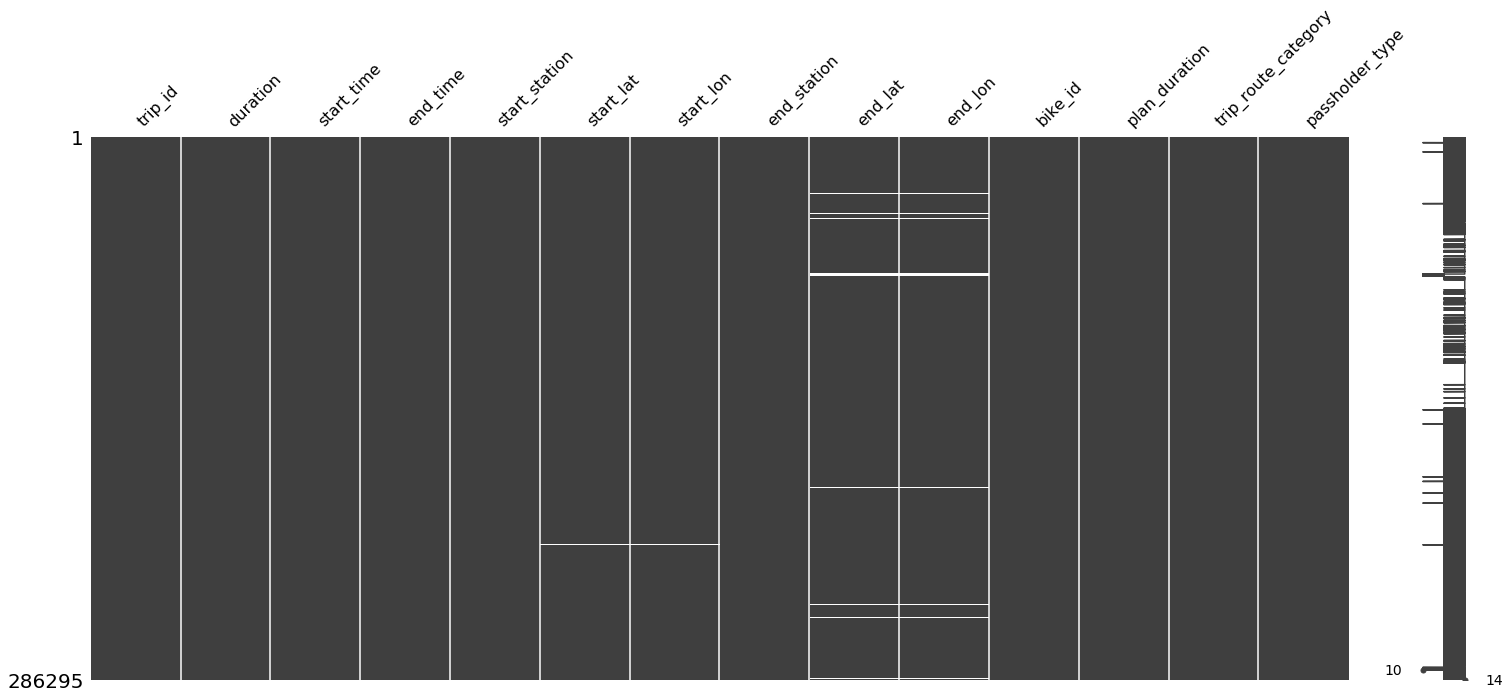

In [12]:
# Check for missing values.
%matplotlib inline
msno.matrix(rides_df)

In [13]:
# dropping rows with na values
rides_df = rides_df.dropna()
rides_df.shape

(281446, 14)

# External datasets of geolocations

In order to obtain a perspective of where most rides occur and landmarks around LA, we utilize multiple data sources and APIs to obtain the relevant latitude and longitude values.

### Bike station locations
We first start off with more detailed information on the bike stations. To do this, we download the json file from https://bikeshare.metro.net/stations/json/ which includes addresses and capacities of different bike stations.

In [14]:
# Read in the json file with station information.
with open ('../data/external/bike_stations.json') as f:
    station_data = json.load(f)

In [15]:
# Extract useful columns from the jason and append it to a list.
all_station_info = []
for station in station_data['features']: 
    station_attr = []
    station_attr.append([station['properties']['kioskId'], station['properties']['addressStreet'], 
                         station['properties']['addressZipCode'], station['properties']['name'],
                         station['properties']['totalDocks']])
    all_station_info.append(station_attr[0])

In [16]:
# Check to see if each element in list is a list of station attributes we need.
all_station_info[2]

[3007, '557 S 5th Street', '90071', '5th & Grand', 23]

In [17]:
# Create new dataframe based on the attributes.
stations_info = pd.DataFrame(all_station_info, columns=['kiosk_id','address_street','address_zip','station_name','total_docks'])
stations_info.head()

,kiosk_id,address_street,address_zip,station_name,total_docks
0,3005,723 Flower Street,90017,7th & Flower,27
1,3006,729 S Olive Street,90014,Olive & 8th,24
2,3007,557 S 5th Street,90071,5th & Grand,23
3,3008,865 S Figueroa Street,90017,Figueroa & 9th,15
4,3010,401 East 11th Street,90015,11th & Maple,22


In [18]:
# Adding start station attributes.
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'start_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'start_address',
                                                          'address_zip':'start_zip','station_name':'start_name',
                                                          'total_docks':'start_docks'}).drop('kiosk_id',1)
# Adding end station attributes.
rides_df = pd.merge(rides_df, stations_info, how = "left", left_on = 'end_station', 
               right_on = ['kiosk_id']).rename(columns = {'address_street':'end_address',
                                                          'address_zip':'end_zip','station_name':'end_name',
                                                          'total_docks':'end_docks'}).drop('kiosk_id',1)

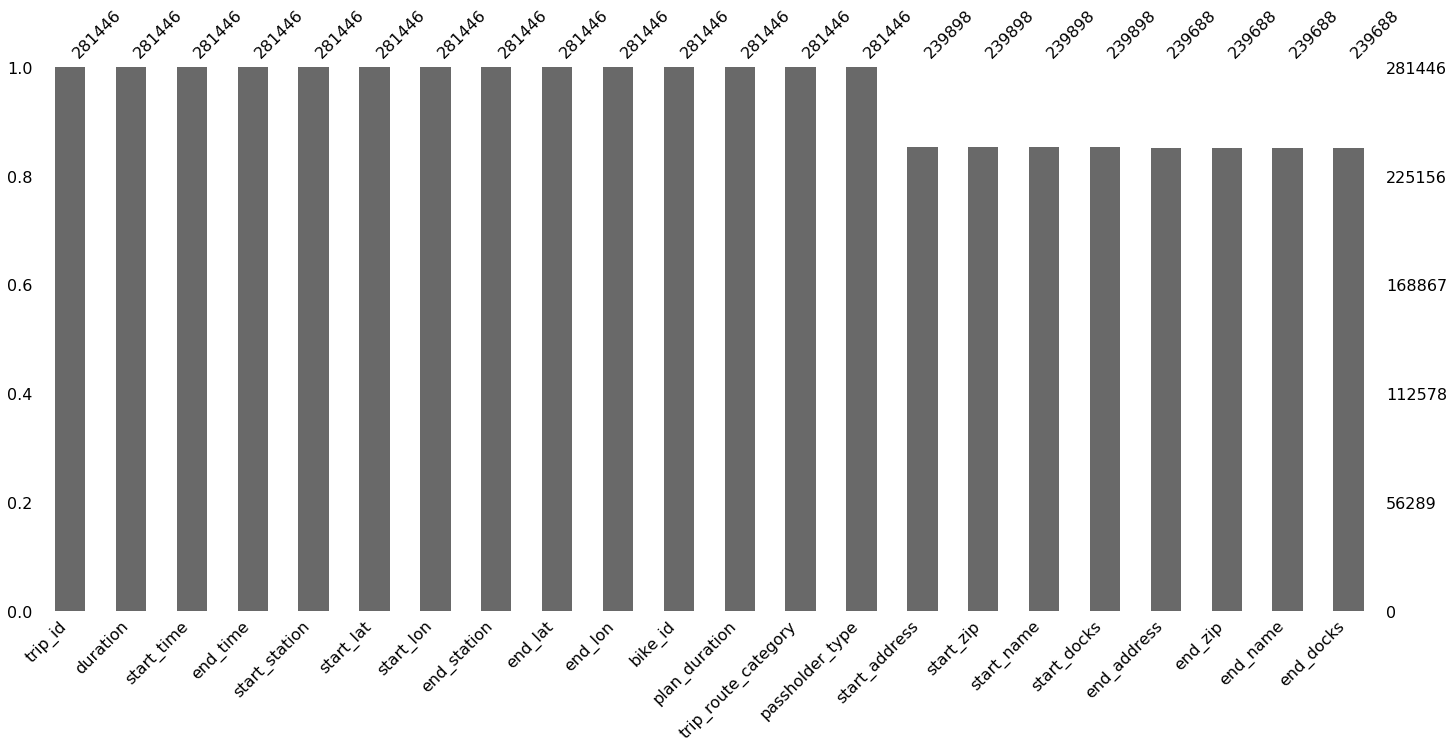

In [19]:
# Checking for missing address details.
msno.bar(rides_df)

There seems to be about 20% of entries with missing station information. As this is a sizeable portion of the dataset, we can take a closer look to see how to deal with these missing values.

In [20]:
# By looking at the descriptive statistic on counts of distinct stations, there is certainly a huge range present
# with a single station appearing 11429 times.
rides_df['start_station'].value_counts().describe()

count      124.000000
mean      2269.725806
std       2154.035881
min          6.000000
25%        804.500000
50%       1544.500000
75%       3019.500000
max      11437.000000
Name: start_station, dtype: float64

In [21]:
# The descriptive statistics on the number of docks reveal an average and median value of around 22.
rides_df['start_docks'].describe()

count    239898.000000
mean         22.869882
std           5.119422
min          13.000000
25%          19.000000
50%          22.000000
75%          27.000000
max          36.000000
Name: start_docks, dtype: float64

In [22]:
# A mask is created to filter out station records that have any missing values that appear more than the
# median count across stations
median_mask = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts() \
                 > rides_df['start_station'].value_counts().median()

# The main dataframe is filtered by the above mask and keys are obtained. This gives us the station id's to
# fill
locations_to_fill = rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts()[median_mask]
locations_to_fill.keys()

Int64Index([4162, 4153, 4181, 4165, 4176, 4142, 4157, 4180, 4163, 4159, 4177], dtype='int64')

In [23]:
str(round(locations_to_fill.sum()/rides_df[rides_df.isnull().any(axis = 1)]['start_station'].value_counts().sum(),2)*100) + '%'

'47.0%'

In [24]:
lats = []
longs = []
for station_id in locations_to_fill.keys():
    lats.append(rides_df['start_lat'][rides_df['start_station'] == station_id].iloc[0])
    longs.append(rides_df['start_lon'][rides_df['start_station'] == station_id].iloc[0])

In [25]:
manual_add_cols = list(stations_info.columns)
manual_add_cols.extend(('start_lat','start_lon'))
manual_add_cols[0] = 'start_station'
manual_kiosk_add = pd.DataFrame(columns = manual_add_cols)
manual_kiosk_add['start_station'] = np.asarray(locations_to_fill.keys())
manual_kiosk_add['end_station'] = manual_kiosk_add['start_station']
manual_kiosk_add['start_lat'] = np.asarray(lats)
manual_kiosk_add['start_lon'] = np.asarray(longs)
manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,NaN,NaN,NaN,NaN,34.147499,-118.148010,4162
1,4153,NaN,NaN,NaN,NaN,34.156181,-118.166687,4153
2,4181,NaN,NaN,NaN,NaN,34.146221,-118.135262,4181
3,4165,NaN,NaN,NaN,NaN,34.141750,-118.149063,4165
4,4176,NaN,NaN,NaN,NaN,34.137859,-118.122414,4176
5,4142,NaN,NaN,NaN,NaN,34.144588,-118.144592,4142
6,4157,NaN,NaN,NaN,NaN,34.140999,-118.132088,4157
7,4180,NaN,NaN,NaN,NaN,34.137951,-118.128502,4180
8,4163,NaN,NaN,NaN,NaN,34.150471,-118.132019,4163
9,4159,NaN,NaN,NaN,NaN,34.145901,-118.116539,4159


In [26]:
manual_street_addresses = []
manual_zips = []
manual_names = []
manual_street_addresses.extend(('136 E Holly St','1001 Rose Bowl Dr','2-26 N Oak Knoll Ave','272-260 S Raymond Ave', '1320-1342 San Pasqual St', '300 E Green St', '270 S Lake Ave', '1085-1041 San Pasqual St', '300 N Lake Ave','1570 E Colorado Blvd','50 S Madison Ave'))
manual_zips.extend((91103, 91103, 91101, 91105, 91106, 91101, 91101, 91106, 91101, 91106, 91101))
manual_names.extend(('Memorial Park Station', 'Rose Bowl Stadium', 'E Colorado Blvd Target','Central Park','Caltech Student Services','Pasadena Civic Auditorium', 'The Shops on Lake Avenue','Caltech Graduate Housing', 'Gateway Plaza', 'Pasadena City College Shatford Library', 'Playhouse parking lot'))

In [27]:
manual_kiosk_add['address_street'] = np.asarray(manual_street_addresses)
manual_kiosk_add['address_zip'] = np.asarray(manual_zips)
manual_kiosk_add['station_name'] = np.asarray(manual_names)
manual_kiosk_add = manual_kiosk_add.fillna(22)

manual_kiosk_add

,start_station,address_street,address_zip,station_name,total_docks,start_lat,start_lon,end_station
0,4162,136 E Holly St,91103,Memorial Park Station,22,34.147499,-118.148010,4162
1,4153,1001 Rose Bowl Dr,91103,Rose Bowl Stadium,22,34.156181,-118.166687,4153
2,4181,2-26 N Oak Knoll Ave,91101,E Colorado Blvd Target,22,34.146221,-118.135262,4181
3,4165,272-260 S Raymond Ave,91105,Central Park,22,34.141750,-118.149063,4165
4,4176,1320-1342 San Pasqual St,91106,Caltech Student Services,22,34.137859,-118.122414,4176
5,4142,300 E Green St,91101,Pasadena Civic Auditorium,22,34.144588,-118.144592,4142
6,4157,270 S Lake Ave,91101,The Shops on Lake Avenue,22,34.140999,-118.132088,4157
7,4180,1085-1041 San Pasqual St,91106,Caltech Graduate Housing,22,34.137951,-118.128502,4180
8,4163,300 N Lake Ave,91101,Gateway Plaza,22,34.150471,-118.132019,4163
9,4159,1570 E Colorado Blvd,91106,Pasadena City College Shatford Library,22,34.145901,-118.116539,4159


In [28]:
# Function to use the df.where function to map values to original dataframe.
def fill_df_null(df1, df2, target_col, common_col, alt_name):
    df1[target_col] = df1[target_col].where(df1[target_col].notnull(), 
                                           df1[common_col].map(df2.set_index(common_col)[alt_name]))

fill_df_null(rides_df, manual_kiosk_add, 'start_address', 'start_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'start_zip', 'start_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'start_name', 'start_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'start_docks', 'start_station', 'total_docks')

fill_df_null(rides_df, manual_kiosk_add, 'end_address', 'end_station', 'address_street')
fill_df_null(rides_df, manual_kiosk_add, 'end_zip', 'end_station', 'address_zip')
fill_df_null(rides_df, manual_kiosk_add, 'end_name', 'end_station', 'station_name')
fill_df_null(rides_df, manual_kiosk_add, 'end_docks', 'end_station', 'total_docks')

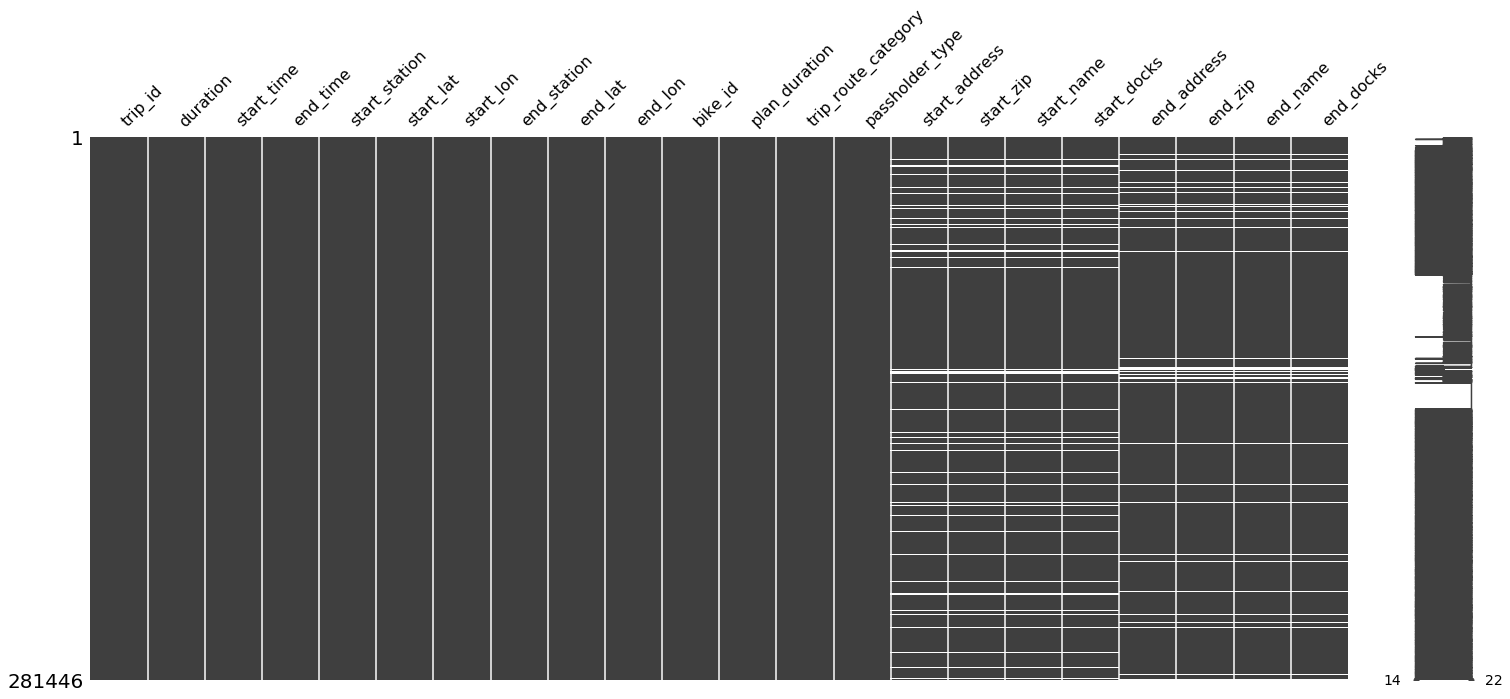

In [29]:
msno.matrix(rides_df)

In [30]:
rides_df = rides_df.dropna()

In [31]:
rides_df.shape

(250513, 22)

### Further feature engineering

In [32]:
# Create label for rides that were charged based on current pricing plan.
def label_charged(duration):
    if duration <= 30:
        return 0
    else:
        return 1

rides_df['charged_ride'] = rides_df['duration'].apply(label_charged)

In [33]:
# Column for hour of day of ride.
rides_df['start_hour'] = rides_df['start_time'].dt.hour

In [34]:
latest_ride_date = rides_df['end_time'].max()
latest_ride_date

Timestamp('2018-07-02 00:09:00')

In [35]:
bike_last_used_id = bike_last_used = rides_df.groupby('bike_id')['end_time'].max().keys().tolist()
bike_last_used_date = rides_df.groupby('bike_id')['end_time'].max().tolist()

In [36]:
# Number of bikes active each month in the past year.
for month in range(1,13):
    print(month, len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if 
                      record[1] > latest_ride_date + np.timedelta64(-month, 'M') ]))

1 1259
2 1353
3 1383
4 1409
5 1415
6 1419
7 1427
8 1436
9 1442
10 1445
11 1448
12 1452


In [37]:
# Number of inactive bikes (bikes that haven't been used in the past 6 months)
len([record for record in list(zip(bike_last_used_id,bike_last_used_date)) if 
     record[1] < latest_ride_date + np.timedelta64(-6, 'M') ])

33

In [38]:
# Create feature indicating active bikes, used in past 6 months. 1 if active, 0 if inactive.
inactive_ids = [record[0] for record in list(zip(bike_last_used_id,bike_last_used_date)) if 
                record[1] < latest_ride_date + np.timedelta64(-6, 'M') ]
rides_df['active_6m'] = rides_df['bike_id'].apply(lambda bike_id: 0 if bike_id in (inactive_ids) else 1)

In [39]:
# Listing out unique values for dummy variables.
rides_df['passholder_type'].unique()

array(['Walk-up', 'Monthly Pass', 'Flex Pass', 'One Day Pass'],
      dtype=object)

In [40]:
# Create dummy variables for passholder type.
one_hot_pass = pd.get_dummies(rides_df['passholder_type']).rename(columns={
    'Flex Pass' : 'annual',
    'Monthly Pass' : 'monthly',
    'One Day Pass' : 'one_day',
    'Walk-up' : 'walk_up'
})

# Create dummy variables for trip route category.
one_hot_trip_type = pd.get_dummies(rides_df['trip_route_category']).rename(columns = {
    'One Way' : 'one_way',
    'Round Trip' : 'round_trip'
})

rides_df = rides_df.join([one_hot_pass, one_hot_trip_type])

In [41]:
# Walk-up  3.50/30minutesAlltrips30minutesorlessare3.50/30minutesAlltrips30minutesorlessare 3.50 
# $3.50 per 30 minutes thereafter
# Find a Station One Day Pass  7/dayAlltrips30minutesorlessarefree7/dayAlltrips30minutesorlessarefree 
# 1.75 per 30 minutes thereafter
# Buy a Pass Monthly Pass  20/monthAlltrips30minutesorlessarefree20/monthAlltrips30minutesorlessarefree 
# 1.75 per 30 minutes thereafter
# determining pricing based on the following scheme:

In [42]:
rides_df[rides_df['passholder_type'] == 'Flex Pass'].iloc[1]

trip_id                                   33463066
duration                                        18
start_time                     2017-07-01 11:34:00
end_time                       2017-07-01 11:52:00
start_station                                 3011
start_lat                                  34.0411
start_lon                                 -118.268
end_station                                   3062
end_lat                                    34.0477
end_lon                                   -118.243
bike_id                                       6634
plan_duration                                  365
trip_route_category                        One Way
passholder_type                          Flex Pass
start_address          1259-1299 S Figueroa Street
start_zip                                    90015
start_name                         Figueroa & Pico
start_docks                                     19
end_address                     350 E Third Street
end_zip                        

In [43]:
rides_df.shape

(250513, 31)

In [44]:
# Creates feature for 30 minute blocks that walk-up users have to pay for.
# Creates another feature for 30 minute blocks for passholders that exclude first 30 minute block.
rides_df['time_block_count'] = rides_df['duration'].apply(lambda duration: math.ceil(duration/30))
rides_df['time_block_count_post_free'] = rides_df['duration'].apply(lambda duration: math.ceil(duration/30)) - 1

In [45]:
pprint.pprint(rides_df.dtypes)

trip_id                                int64
duration                               int64
start_time                    datetime64[ns]
end_time                      datetime64[ns]
start_station                          int64
start_lat                            float64
start_lon                            float64
end_station                            int64
end_lat                              float64
end_lon                              float64
bike_id                                int64
plan_duration                          int64
trip_route_category                   object
passholder_type                       object
start_address                         object
start_zip                             object
start_name                            object
start_docks                          float64
end_address                           object
end_zip                               object
end_name                              object
end_docks                            float64
charged_ri

In [46]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks,charged_ride,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip,time_block_count,time_block_count_post_free
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0


### Current pricing

Walk up   
$ 1.75 for each 30 min trip   
$ 1.75 per 30 minutes thereafter

Day Pass 
$5/day
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Monthly Pass
$17/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter
 

Sign Up
Annual Pass
$150/year
Equivalent to $12.50/month
All rides 30 minutes or less are free
$1.75 per 30 minutes thereafter

### Previous pricing

Walk-up
$3.50/30 minutes
All trips 30 minutes or less are $3.50
$3.50 per 30 minutes thereafter
 

Find a Station
One Day Pass
$7/day
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter


Buy a Pass
Monthly Pass
$20/month
All trips 30 minutes or less are free
$1.75 per 30 minutes thereafter

Buy a Pass
Annual Pass/Flex Pass
$40/year
$1.75 per 30 minutes

### Competitor pricing:

Bird Scooters - $.15 per minute   

Lime Pedal Bikes - $1 to unlock + $0.05/minute to ride.   

Lime-E Electric Assist Bikes - $1 to unlock +  $.15 per minute   

Lime-S Electric Scooters - $1 to unlock + $.15 per minute   

LimePrime - $29.95 per month and includes $100 in ride credits for use on Lime Classic Pedal Bikes only.   

LimePrime Students is $14.95 per month and includes 100 ride credits, with a valid ".EDU" email address. Students, faculty and staff all qualify.   

JUMP Bikes (& scooters) (Santa Monica only) - $1 for first 5 minutes + $.15 per minute after   

JUMP Bikes (& scooters) Boost Plan (Santa Monica only) - $5 a month for 60 minutes a day of ride time + .07 after 60 min.

## Optimization models

As seen from competitors, there are multiple ways in which the pricing scheme can be structured. Some options that we could implement and compare are as follows:
1. Variable rate by minute
2. Variable rate by time intervals (30 minutes for LA Metro currently)
3. Fixed fee for any ride
4. Fixed fee for a time interval before implementing a variable rate
5. Weekly, monthly passes that cover all rides up to a particular duration. Variable rate thereafter

We will examine the current model by LA metro and whether the current level of customer segmentation is necessary. To benchmark the pricing against other operators of bikes and scooters, let's plot out the different pricing curves for all operators.

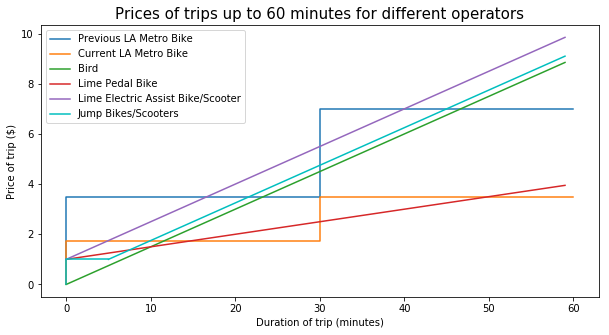

In [47]:
fig, axes = plt.subplots(figsize=(10,5))
x = np.array(range(0,60))
prev_la, = plt.step([0,30,60], [0,3.5,7], label = 'Previous LA Metro Bike')
cur_la, = plt.step([0,30,60], [0,1.75,3.5], label = 'Current LA Metro Bike')
bird, = plt.plot(x, 0.15 * x, label = 'Bird')
lime_ped, = plt.plot(x, 1 + 0.05 * x, label = 'Lime Pedal Bike')
lime_scoot, = plt.plot(x, 1 + 0.15 * x, label = 'Lime Electric Assist Bike/Scooter')
jump1, = plt.step([0,5],[0,1],label = 'Jump Bikes/Scooters',color = 'c')
jump2, = plt.plot(np.array(range(5,60)), 0.15 * np.array(range(5,60)) + 0.25, color = 'c')
plt.title('Prices of trips up to 60 minutes for different operators', size=15)
plt.xlabel('Duration of trip (minutes)')
plt.ylabel('Price of trip ($)')
plt.legend()
plt.show()

Looking at the different pricing schemes across bike and scooter operators in LA, the current pricing that was just enacted by LA Metro is definitely the cheapest, coming in at $3.50 for an hour long bike ride.

The previous pricing for an hour long bike ride for a walk-on was $7, twice the current price.

The next cheapest option is the Lime pedal bike, which is cheaper than walk on riders on LA metro for rides shorter than 15 minutes and for rides between 30 and 50 minutes. 

We will thus formulate the following linear constraints to optimize total revenue for the current pricing structure:   
1. The variable rate per minute without a pass is set under the average of the two most common prices of \$0.05 and \$0.15:    
Variable rate per minute without pass <= \$0.10
2. The variable rate per minute with a plan is set under the average of the LA Metro's current ~\$0.06 and Jump's \$0.07:   
Variable rate per minute with pass <= \$0.065 
3. The variable rate is set under the nearest competitor(Lime pedal):   
Variable rate per 30 minutes <= \$2.5
4. As there aren't many operators out there with comparable pass pricing plans, we maintain the current prices of 5, 17, and 150 for daily pass, monthly pass, and annual pass respectively:      
Daily pass price <= \$5   
Monthly pass price <= \$17   
Annual pass price <= \$150

In [48]:
%store rides_df

Stored 'rides_df' (DataFrame)


In [49]:
pass_groups = rides_df.groupby('passholder_type')
pass_groups.groups.keys()

dict_keys(['Flex Pass', 'Monthly Pass', 'One Day Pass', 'Walk-up'])

In [50]:
agg_pass_groups = pass_groups.agg({
    'trip_id' : 'count',
    'walk_up' : 'sum',
    'time_block_count' : 'sum',
    'time_block_count_post_free' : 'sum',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id' : 'total_trips',
    'walk_up' : 'pay_count_walk_up',
    'time_block_count' : 'total_30min_blocks',
    'time_block_count_post_free' : 'total_30min_blocks_post_free',
    'duration' : 'total_minutes'
}).reset_index()
agg_pass_groups['passholder_type'] = ['annual','monthly','daily','walk_up']
agg_pass_groups.index = agg_pass_groups['passholder_type']
agg_pass_groups = agg_pass_groups.drop('passholder_type',1)
agg_pass_groups

,total_trips,pay_count_walk_up,total_30min_blocks,total_30min_blocks_post_free,total_minutes
passholder_type,,,,,
annual,9175,0.0,10858,1683,143708
monthly,146531,0.0,165592,19061,1982585
daily,14640,0.0,38517,23877,937578
walk_up,80167,80167.0,178895,98728,4158810


We are however missing the number of passholders to implement revenue gained from selling passes. As we do not have unique identifiers for passholders, we refer to the data page of LA Metro bikes here: https://bikeshare.metro.net/about/data/.

With roughly 575,281 trips completed and 42,870 passes sold since it's inception in July 2016, it would be safe to expect roughly 20,000 passes sold during the year-long period of this analysis. 

We will estimate the number of different passes sold from a breakeven perspective. As most trips (>60%) are "last mile" trips from metro stops and the median duration of trips is 12 minutes, we conduct the following breakeven analysis for trips under 30 minutes.

In [118]:
# Rides to break even = Pass price / (Price to ride without pass - Price to ride with pass)
# Passes sold = Total rides / Rides to break even

price_wo_pass = 3.5
price_w_pass_day = 0
price_w_pass_month = 0
price_w_pass_annual = 1.75

# Average difference between passholders and walk-up riders across previous and current pricing.
# This is represented by the difference in prices per 30 minute block since pass holders get the first 30 minutes free.
# As current data is from before the price change, previous prices are used to estimate number of passes.

day_diff = price_wo_pass - price_w_pass_day
month_diff = price_wo_pass - price_w_pass_month
annual_diff = price_wo_pass - price_w_pass_annual

# Prices of passes.

day_pass_price = 7
month_pass_price = 20
annual_pass_price = 40

# Estimated rides required for breakeven.

rides_day_pass_estimate = day_pass_price / day_diff
rides_month_pass_estimate = month_pass_price / month_diff
rides_annual_pass_estimate = annual_pass_price / annual_diff

print(" Rides per day required for daily pass:",rides_day_pass_estimate,'\n', 
      "Rides per month required for monthly pass:", rides_month_pass_estimate,'\n', 
      "Rides per year required for annual pass:", rides_annual_pass_estimate)

 Rides per day required for daily pass: 2.0 
 Rides per month required for monthly pass: 5.714285714285714 
 Rides per year required for annual pass: 22.857142857142858


Looking at the number of rides required of breakeven and assessing the numbers, the numbers seem to be on the low side. 

Daily pass holders are likely to perform more than a round trip if they were purchasing a day pass.

Monthly pass holders are likely to be the occasional commuters and even at a conservative 2 rides/week to work would tally 8 rides a month.

Annual pass holders are the hardest to gauge due to the low $40 price point of the flex point from the previous pricing plan. For now, they'll be scaled to the same factor as day and monthly pass numbers.

Scaling daily passes up to a conservative 3 rides is a 50% increase in rides while scaling monthly rides up to a conservative 8 rides is a 40% increase. For conservative estimates, we scale the three estimates by a common factor of 40%.

In [119]:
rides_day_pass_estimate *= 1.4
rides_month_pass_estimate *= 1.4
rides_annual_pass_estimate *= 1.4

print("Rides per day required for daily pass (scaled):",rides_day_pass_estimate,'\n', 
      "Rides per month required for monthly pass (scaled):", rides_month_pass_estimate,'\n', 
      "Rides per year required for annual pass (scaled):", rides_annual_pass_estimate)

Rides per day required for daily pass (scaled): 2.8 
 Rides per month required for monthly pass (scaled): 8.0 
 Rides per year required for annual pass (scaled): 32.0


In [53]:
# Divide total trips by rides required for breakeven per pass duration (day/month/year) to get estimated number
# of passholders.

passes_sold_day = math.ceil(agg_pass_groups.loc['daily','total_trips']/rides_day_pass_estimate)
passes_sold_month = math.ceil(agg_pass_groups.loc['monthly','total_trips']/rides_month_pass_estimate)
passes_sold_annual = math.ceil(agg_pass_groups.loc['annual','total_trips']/rides_annual_pass_estimate)
passes_sold_total = passes_sold_day + passes_sold_month + passes_sold_annual

agg_pass_groups['passes_sold'] = [passes_sold_annual, passes_sold_month, passes_sold_day, 0]

print("Estimated passes sold for daily pass:",passes_sold_day,'\n', 
      "Estimated passes sold for monthly pass:", passes_sold_month,'\n', 
      "Estimated passes sold for annual pass:", passes_sold_annual,'\n',
     "Total passes sold:", passes_sold_total)

Estimated passes sold for daily pass: 5229 
 Estimated passes sold for monthly pass: 18317 
 Estimated passes sold for annual pass: 287 
 Total passes sold: 23833


The total number of estimated passes bought during this period is around 23,833. This is roughly inline with our previous estimate of 20,000.

Lets now formulate the objective function for this optimization model to maximum total revenue from pass sales and rides.

The total revenue can be split into the following:
1. Total revenue from walk up users = Price for 30 minutes of usage * Total 30 minute blocks by walk up users
2. Total revenue from day, month pass users = Price for 30 minutes of usage * Total 30 minute blocks after free first 30 minutes
3. Total revenue from selling passes = Prices of respective passes * Total passes sold in respective pass types

Now we can represent this objective function in PuLP.

In [54]:
agg_pass_groups['previous_pass_prices'] = [40, 20, 7, 0]
agg_pass_groups['new_pass_prices'] = [40,17, 5, 0]
agg_pass_groups['average_charged_blocks_per_ride'] = agg_pass_groups['total_30min_blocks_post_free'] / agg_pass_groups['total_trips']
agg_pass_groups['percent_total_trips'] = agg_pass_groups['total_trips']/sum(agg_pass_groups['total_trips'])
agg_pass_groups

,total_trips,pay_count_walk_up,total_30min_blocks,total_30min_blocks_post_free,total_minutes,passes_sold,previous_pass_prices,new_pass_prices,average_charged_blocks_per_ride,percent_total_trips
passholder_type,,,,,,,,,,
annual,9175,0.0,10858,1683,143708,287,40,40,0.183433,0.036625
monthly,146531,0.0,165592,19061,1982585,18317,20,17,0.130082,0.584924
daily,14640,0.0,38517,23877,937578,5229,7,5,1.630943,0.058440
walk_up,80167,80167.0,178895,98728,4158810,0,0,0,1.231529,0.320011


In [108]:
%store agg_pass_groups

Stored 'agg_pass_groups' (DataFrame)


Let's first run a quick calculation to see what our current total revenue is with the estimated number of passholders over the past year.

The old pricing scheme is used here to estimate the price. Here, annual passholders pay \$40 a year for a flex pass and $1.75 for every half hour. The first half hour is not free.

In [55]:
current_tot_rev = (sum(3.5 * agg_pass_groups['pay_count_walk_up']) 
                   + sum(1.75 * agg_pass_groups['total_30min_blocks_post_free'])
                   + 1.75 * (agg_pass_groups['total_30min_blocks'] ['annual']
                                            - agg_pass_groups['total_30min_blocks_post_free']['annual'])
                   + sum(agg_pass_groups['passes_sold'] * agg_pass_groups['previous_pass_prices']))
print('Total revenue: $', current_tot_rev)

Total revenue: $ 961924.5


### Basic linear optimization with PuLP

Let's first try basic linear optimizations with PuLP before moving on to more advanced quadratic programming.

While the price and demand relationship is probably the most interesting one, another question that could be asked is if all plans are necessary for revenue maximization. We thus create binary variables for each plan and run a basic optimization over both previous and current price plans.

Given that riders have already been complaining about the $3.50 per half hour block rate, any dropping of passes in the past pricing scheme would have led to a precipitous drop in ridership. Furthermore, given the fierce competition in the area of bike and scooter sharing, the dropping of certain passes could simply lead to riders moving to other competitors.

We assume a baseline attrition of 30% for each category and adjust the parameters as we run the model.

In [56]:
from pulp import *

In [57]:
previous_walk_up = 3.5
previous_pass = 1.75

# Model version 1 for previous pricing

model_v1 = pulp.LpProblem("Revenue Maximization Previous", pulp.LpMaximize)

# List of all binary variables.

day_yes = pulp.LpVariable('day_yes', cat='Binary')

day_no = pulp.LpVariable('day_no', cat='Binary')

month_yes = pulp.LpVariable('month_yes', cat='Binary')

month_no = pulp.LpVariable('month_no', cat='Binary')

annual_yes = pulp.LpVariable('annual_yes', cat='Binary')

annual_no = pulp.LpVariable('annual_no', cat='Binary')

# Objective function.
# Revenue for walk ups
walk_up_rev_block = previous_walk_up * agg_pass_groups.loc['walk_up','total_30min_blocks']

# Revenue for pass sales.
trip_rev_day_pass = agg_pass_groups.loc['daily', 'total_30min_blocks_post_free'] * day_yes * previous_pass
trip_rev_month_pass = agg_pass_groups.loc['monthly', 'total_30min_blocks_post_free'] * month_yes * previous_pass
trip_rev_annual_pass = agg_pass_groups.loc['annual', 'total_30min_blocks'] * annual_yes * previous_pass

# Revenue for pass sales is pass is cancelled.
trip_rev_day_no_pass = agg_pass_groups.loc['daily', 'total_30min_blocks'] * previous_walk_up * day_no * 0.7
trip_rev_month_no_pass = agg_pass_groups.loc['monthly', 'total_30min_blocks'] * previous_walk_up * month_no * 0.7
trip_rev_annual_no_pass = agg_pass_groups.loc['annual', 'total_30min_blocks'] * previous_walk_up * annual_no * 0.7

# Revenue for sales of passes.
pass_sales_rev_day = (day_yes * agg_pass_groups.loc['daily','previous_pass_prices'] 
                      * agg_pass_groups.loc['daily','passes_sold'])
pass_sales_rev_month = (month_yes * agg_pass_groups.loc['monthly','previous_pass_prices'] 
                        * agg_pass_groups.loc['monthly','passes_sold'])
pass_sales_rev_annual = (annual_yes * agg_pass_groups.loc['annual','previous_pass_prices'] 
                         * agg_pass_groups.loc['annual','passes_sold'])

# Adding objective function to model
model_v1 += pulp.lpSum(walk_up_rev_block + trip_rev_day_pass + trip_rev_day_no_pass + trip_rev_month_pass 
                       + trip_rev_month_no_pass + trip_rev_annual_pass + trip_rev_annual_no_pass 
                       + pass_sales_rev_day + pass_sales_rev_month + pass_sales_rev_annual)

# Constraints such that only one of each binary pair can be true.
model_v1 += day_yes + day_no == 1
model_v1 += month_yes + month_no == 1
model_v1 += annual_yes + annual_no == 1

optimization_result = model_v1.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[model_v1.status])
print("Optimal Solution to the problem: ", value(model_v1.objective))
print ("Individual decision_variables: ")
for v in model_v1.variables():
	print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  1156681.05
Individual decision_variables: 
annual_no = 0.0
annual_yes = 1.0
day_no = 1.0
day_yes = 0.0
month_no = 1.0
month_yes = 0.0


In [58]:
print(model_v1)

Revenue Maximization Previous:
MAXIMIZE
26602.1*annual_no + 30481.5*annual_yes + 94366.65*day_no + 78387.75*day_yes + 405700.39999999997*month_no + 399696.75*month_yes + 626132.5
SUBJECT TO
_C1: day_no + day_yes = 1

_C2: month_no + month_yes = 1

_C3: annual_no + annual_yes = 1

VARIABLES
0 <= annual_no <= 1 Integer
0 <= annual_yes <= 1 Integer
0 <= day_no <= 1 Integer
0 <= day_yes <= 1 Integer
0 <= month_no <= 1 Integer
0 <= month_yes <= 1 Integer



After adjusting some parameters and attrition rates, we arrive at the following:   

Day plans should be dropped if sales drop by less than 41% from the cancellation.   
Monthly plans should be dropped if sales drop by less than 31% from the cancellation.   
Annual plans should be dropped if sales drop by less than 19% from the cancellation.   
   
Total revenue at these edge attrition rates yield us an optimized $ 1,136,357 total revenue.   

Let's now repeat the same scheme for the current pricing where rates have been halved.    
As the new annual pricing scheme is completely separate from the previous annual (flex) pass, we maintain the $40 annual pass price. The $150 price is factored into later optimizations.

In [59]:
current_walk_up = 1.75
current_pass = 1.75

# Model version 2 for current pricing

model_v2 = pulp.LpProblem("Revenue Maximization Previous", pulp.LpMaximize)

# List of all binary variables.

day_yes = pulp.LpVariable('day_yes', cat='Binary')

day_no = pulp.LpVariable('day_no', cat='Binary')

month_yes = pulp.LpVariable('month_yes', cat='Binary')

month_no = pulp.LpVariable('month_no', cat='Binary')

annual_yes = pulp.LpVariable('annual_yes', cat='Binary')

annual_no = pulp.LpVariable('annual_no', cat='Binary')

# Objective function.
# revenue for walk ups
walk_up_rev_block = price_wo_pass * agg_pass_groups.loc['walk_up','total_30min_blocks']

# Revenue for passholders.
trip_rev_day_pass = agg_pass_groups.loc['daily', 'total_30min_blocks_post_free'] * day_yes * current_pass
trip_rev_month_pass = agg_pass_groups.loc['monthly', 'total_30min_blocks_post_free'] * month_yes * current_pass
trip_rev_annual_pass = agg_pass_groups.loc['annual', 'total_30min_blocks_post_free'] * annual_yes * current_pass

# Revenue for passholders if no passes available.
trip_rev_day_no_pass = agg_pass_groups.loc['daily', 'total_30min_blocks'] * current_walk_up * day_no
trip_rev_month_no_pass = agg_pass_groups.loc['monthly', 'total_30min_blocks'] * current_walk_up * month_no
trip_rev_annual_no_pass = agg_pass_groups.loc['annual', 'total_30min_blocks'] * current_walk_up * annual_no * 0.76

# Revenue for sales of passes.
pass_sales_rev_day = (day_yes * agg_pass_groups.loc['daily','new_pass_prices'] 
                      * agg_pass_groups.loc['daily','passes_sold'])
pass_sales_rev_month = (month_yes * agg_pass_groups.loc['monthly','new_pass_prices'] 
                        * agg_pass_groups.loc['monthly','passes_sold'])
pass_sales_rev_annual = (annual_yes * agg_pass_groups.loc['annual','new_pass_prices'] 
                         * agg_pass_groups.loc['annual','passes_sold'])

# Adding objective function to model
model_v2 += pulp.lpSum(walk_up_rev_block + trip_rev_day_pass + trip_rev_day_no_pass + trip_rev_month_pass 
                       + trip_rev_month_no_pass + trip_rev_annual_pass + trip_rev_annual_no_pass 
                       + pass_sales_rev_day + pass_sales_rev_month + pass_sales_rev_annual)

# Constraints such that only one of each binary pair can be true.
model_v2 += day_yes + day_no == 1
model_v2 += month_yes + month_no == 1
model_v2 += annual_yes + annual_no == 1

optimization_result = model_v2.solve()

assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[model_v2.status])
print("Optimal Solution to the problem: ", value(model_v2.objective))
print ("Individual decision_variables: ")
for v in model_v2.variables():
	print(v.name, "=", v.varValue)

Status: Optimal
Optimal Solution to the problem:  1053249.14
Individual decision_variables: 
annual_no = 1.0
annual_yes = 0.0
day_no = 0.0
day_yes = 1.0
month_no = 0.0
month_yes = 1.0


Given the drastic measure of slashing half hour rates by half to $ 1.75, it is unlikely for attrition to be as high should any plan be cancelled.   
Furthermore, the current optimum solution suggests that even if there was no attrition and we could charge every pass holder by the walk-up price, the daily and monthly passes should be kept.   
The annual plan, on the other hand, should only be kept if more than 25% of annual pass holders attrit upon a plan cancellation. Given that annual pass holders are the least likely to attrit as they probably do require the service for commuting if they paid for the pass, LA Metro's recent decision to axe this annual (Flex) plan could well be the right move.

### Quadratic Optimization

Judging from the above linear optimization results, we keep the daily and monthly plans in our pricing scheme. We will also replace the previous annual (Flex) plan with the new plan costing $150 per annum.

We now move on to quadratic optimization for two main factors: price and number of rides. If we had simply run a linear optimization with an upper bound for price, the model would intuitively move towards the upper bound for our optimization problem.

We would thus need to factor in a demand curve that would vary total rides taken along with the price charged for each half hour block.

### Demand curve estimation

It was during the end of this write-up that 2018 Q3 figures were released for LA Metro Bikes. It might just be an additional data point but we can now fit a rudimentary linear demand curve for model constraints to allow price and demand to fluctuate.

2018 Q2 was the last datapoint before the price change and 2018 Q3 was the first after. We set y as price for every 30 minute ride and x as the total number of riders in that quarter.

In [60]:
x1 = 77357
x2 = 95283
y1 = 3.5
y2 = 1.75

slope = (y2-y1)/(x2-x1)
intercept = y2 - x2 * slope

def print_func(slope, intercept):
    print('The linear function from two data points is: y =',slope,'x +',intercept)
    print('Where y = price for half hour block\n      x = rides in fiscal quarter')

print_func(slope, intercept)

The linear function from two data points is: y = -9.762356353899364e-05 x + 11.05186600468593
Where y = price for half hour block
      x = rides in fiscal quarter


### Demand curves by customer segments

What if we broke down demand by customer segments?

We start by creating grouped tables across 2018 Q2 and 2018 Q3.

In [61]:
new_data = pd.read_csv('../data/external/2018Q3.csv')
old_data = pd.read_csv('../data/external/2018Q2.csv')

new_riders = new_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})


old_riders= old_data.groupby('passholder_type').agg({
    'trip_id' : 'count',
    'duration' : 'sum'
}).rename(columns = {
    'trip_id':'total_trips',
    'duration':'total_minutes'
})

old_riders['percent_total_trips'] = old_riders['total_trips']/sum(old_riders['total_trips'])

new_riders['percent_total_trips'] = new_riders['total_trips']/sum(new_riders['total_trips'])

old_riders

,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Flex Pass,2420,44561,0.031284
Monthly Pass,44032,746889,0.569205
One Day Pass,5020,354571,0.064894
Walk-up,25885,1699647,0.334617


In [62]:
new_riders

,total_trips,total_minutes,percent_total_trips
passholder_type,,,
Annual Pass,12,1459,0.000126
Flex Pass,1577,31684,0.016551
Monthly Pass,43967,883475,0.461436
One Day Pass,4737,361091,0.049715
Walk-up,44990,3326240,0.472172


We can see the new annual pass hasn't quite caught on yet, with only 12 passes sold in the pass quarter. The $150 price point might be a little steep up front. 

It is also interesting to note how the price drop hasn't really impacted any of the pass holders but has almost doubled the number of walk-up riders.

Let's see what the other demand curves look like.

In [63]:
slope_walk_up = (1.75-3.5) / (new_riders['total_trips']['Walk-up']-old_riders['total_trips']['Walk-up'])
slope_daily = (1.75-3.5) / (new_riders['total_trips']['One Day Pass']-old_riders['total_trips']['One Day Pass'])
slope_monthly = (1.75-3.5) / (new_riders['total_trips']['Monthly Pass']-old_riders['total_trips']['Monthly Pass'])
slope_annual = (1.75-3.5) / (new_riders['total_trips']['Flex Pass']-old_riders['total_trips']['Flex Pass'])

intercept_walk_up = 1.75 - new_riders['total_trips']['Walk-up'] * slope_walk_up
intercept_daily = 1.75 - new_riders['total_trips']['One Day Pass'] * slope_daily
intercept_monthly = 1.75 - new_riders['total_trips']['Monthly Pass'] * slope_monthly
intercept_annual = 1.75 - new_riders['total_trips']['Flex Pass'] * slope_annual

print('Walk up demand function estimate')
print_func(slope_walk_up, intercept_walk_up)   
print('\n')
print('Daily pass demand function estimate')
print_func(slope_daily, intercept_daily)   
print('\n')
print('Monthly pass demand function estimate')
print_func(slope_monthly, intercept_monthly)
print('\n')
print('Annual(Flex) pass demand function estimate')
print_func(slope_annual, intercept_annual)

Walk up demand function estimate
The linear function from two data points is: y = -9.159905783826223e-05 x + 5.871041612143418
Where y = price for half hour block
      x = rides in fiscal quarter


Daily pass demand function estimate
The linear function from two data points is: y = 0.006183745583038869 x + -27.542402826855124
Where y = price for half hour block
      x = rides in fiscal quarter


Monthly pass demand function estimate
The linear function from two data points is: y = 0.026923076923076925 x + -1181.9769230769232
Where y = price for half hour block
      x = rides in fiscal quarter


Annual(Flex) pass demand function estimate
The linear function from two data points is: y = 0.0020759193357058124 x + -1.5237247924080664
Where y = price for half hour block
      x = rides in fiscal quarter


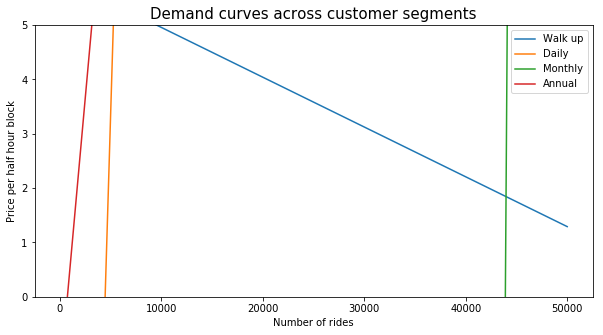

In [64]:
def walk_up_demand(x):
    return slope_walk_up * x + intercept_walk_up

def daily_demand(x):
    return slope_daily * x + intercept_daily

def monthly_demand(x):
    return slope_monthly * x + intercept_monthly

def annual_demand(x):
    return slope_annual * x + intercept_annual

q = np.linspace(0,50000)
fig, axes = plt.subplots(figsize=(10,5))
plt.plot(q, walk_up_demand(q), label = 'Walk up')
plt.plot(q, daily_demand(q), label = 'Daily')
plt.plot(q, monthly_demand(q), label = 'Monthly')
plt.plot(q, annual_demand(q), label = 'Annual')
plt.title('Demand curves across customer segments', size=15)
plt.xlabel('Number of rides')
plt.ylabel('Price per half hour block')
plt.ylim(0,5)
plt.legend()

### Common start end station pairings

In [65]:
from collections import Counter

In [66]:
station_pairings = list(zip(rides_df['start_station'], rides_df['end_station']))

In [67]:
top30_pairs = Counter(station_pairings).most_common(30)

In [68]:
def get_pair_address(tup):
    start_add = rides_df['start_address'][rides_df['start_station'] == tup[0][0]].iloc[0]
    end_add = rides_df['end_address'][rides_df['end_station'] == tup[0][1]].iloc[0]
    return(start_add, end_add)

In [69]:
[get_pair_address(pair) for pair in top30_pairs]

[('Ocean Front Walk @ Navy St', 'Ocean Front Walk @ Navy St'),
 ('2100 Ocean Front Walk', '2100 Ocean Front Walk'),
 ('Ocean Front Walk @ Navy St', '1621 4th St'),
 ('2100 Ocean Front Walk', '1621 4th St'),
 ('1001 Rose Bowl Dr', '1001 Rose Bowl Dr'),
 ('1621 4th St', '1621 4th St'),
 ('120 S Main Street', '834 N Alameda St'),
 ('834 N Alameda St', '120 S Main Street'),
 ('Ocean Front Walk @ Navy St', '2100 Ocean Front Walk'),
 ('2100 Ocean Front Walk', 'Ocean Front Walk @ Navy St'),
 ('3700 Shoshonean Rd', '3700 Shoshonean Rd'),
 ('1621 4th St', 'Ocean Front Walk @ Navy St'),
 ('201 W 7th Street', '723 Flower Street'),
 ('723 Flower Street', '201 W 7th Street'),
 ('200 Rose Ave', '200 Rose Ave'),
 ('2100 Pacific Ave', '2100 Pacific Ave'),
 ('140 Windward Ave', '1621 4th St'),
 ('140 Windward Ave', '140 Windward Ave'),
 ('1222 Abbot Kinney Blvd', '1222 Abbot Kinney Blvd'),
 ('200 Rose Ave', '1621 4th St'),
 ('1621 4th St', '2100 Ocean Front Walk'),
 ('1210 East 5th Street', '1210 East 

### Common time periods

In [70]:
%matplotlib inline
x = sorted(list(zip(rides_df['start_hour'].value_counts().keys(), rides_df['start_hour'].value_counts())))

<Container object of 24 artists>

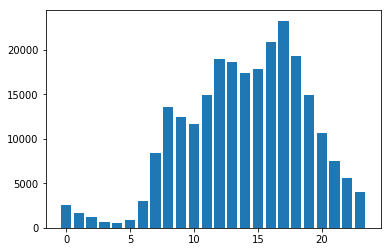

In [71]:
plt.bar(*zip(*x))

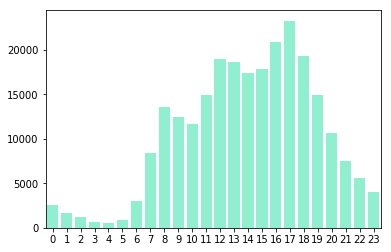

In [72]:
sb.barplot(x=list(list(zip(*x))[0]),
           y=list(list(zip(*x))[1]),
          color = 'aquamarine')

### Heatmaps for different time periods

### Start/end station correlation with available docks

### Active businesses

https://data.lacity.org/A-Prosperous-City/Listing-of-Active-Businesses/6rrh-rzua

In [73]:
# reading in csv file of active businesses, could be outside of LA
business_df = pd.read_csv('../data/external/active_businesses.csv')

In [74]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
0,0000000115-0001-3,VINCENZO LABELLA,NaN,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,521 SWARTHMORE 90272-4350,521 SWARTHMORE AVENUE,PACIFIC PALISADES,90272-4350,561500.0,Travel arrangement & reservation services,11,01/01/1990,NaN,NaN
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


In [75]:
# check to see how many different cities there are in the column
business_df['CITY'].unique()

array(['PACIFIC PALISADES', 'LOS ANGELES', 'GRANADA HILLS', ..., 'ARDEN',
       'LOS BANOS', 'DEBARY'], dtype=object)

As the focus of the ride sharing data is in the LA metro area, we will only focus on the data in that area and only include data with the city variable matching 'Los Angeles'.

By doing so, we see that around 50% of the initial dataset remains.

In [76]:
business_df = business_df[business_df['CITY'] == 'LOS ANGELES']
business_df.shape

(250920, 16)

A look at the dataframe also reveals many NaN values. Using msno, we see that there are multiple columns like 'DBA NAME' and 'MAILING CITY' that are almost completely empty.

There are also many variables that are not as relevant in our analysis. Our main purpose of obtaining the dataset of active businesses is to visualize their locations. We will thus select only the relevant columns and rename them accordingly.

In [77]:
business_df.head()

,LOCATION ACCOUNT #,BUSINESS NAME,DBA NAME,STREET ADDRESS,CITY,ZIP CODE,LOCATION DESCRIPTION,MAILING ADDRESS,MAILING CITY,MAILING ZIP CODE,NAICS,PRIMARY NAICS DESCRIPTION,COUNCIL DISTRICT,LOCATION START DATE,LOCATION END DATE,LOCATION
1,0000000150-0001-5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,2015 W TEMPLE STREET,LOS ANGELES,90026-4913,2015 TEMPLE 90026-4913,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",13,01/01/1991,NaN,NaN
2,0000000156-0001-2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,MONEY MANAGEMENT INTERNATIONAL,1605 W OLYMPIC BLVD #9023,LOS ANGELES,90015-3828,1605 OLYMPIC 90015-3828,NaN,NaN,NaN,523900.0,Other financial investment activities (includi...,1,02/01/1999,NaN,NaN
3,0000000225-0001-5,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,NaN,1715 W FLORENCE AVENUE,LOS ANGELES,90047-2220,1715 FLORENCE 90047-2220,NaN,NaN,NaN,611000.0,"Educational services (including schools, colle...",8,06/03/1997,NaN,NaN
4,0000000247-0001-1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3806 W PICO BLVD,LOS ANGELES,90019-4304,3806 PICO 90019-4304,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN
5,0000000267-0001-9,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,NaN,3115 VENICE BLVD,LOS ANGELES,90019-6238,3115 VENICE 90019-6238,2607 VAN BUREN PLACE,LOS ANGELES,90007-2129,611000.0,"Educational services (including schools, colle...",10,01/01/1991,NaN,NaN


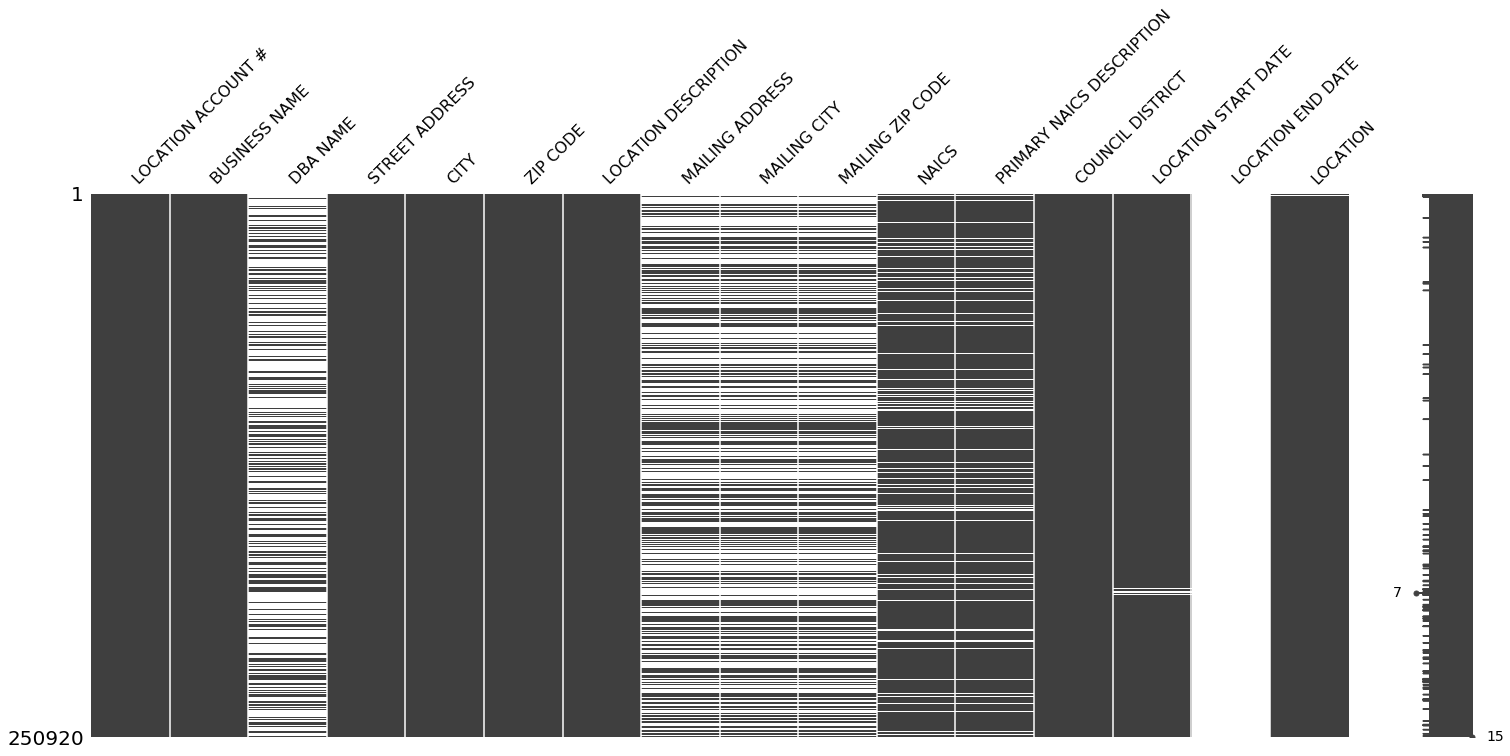

In [78]:
msno.matrix(business_df)

In [79]:
business_df = business_df[['BUSINESS NAME', 'STREET ADDRESS', 'ZIP CODE', 'LOCATION START DATE', 'LOCATION']].rename(columns = {'BUSINESS NAME':'business_name', 'STREET ADDRESS':'street_address', 'ZIP CODE':'zip_code', 'LOCATION START DATE':'start_date', 'LOCATION':'coordinates'})
business_df.head()

,business_name,street_address,zip_code,start_date,coordinates
1,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,2015 W TEMPLE STREET,90026-4913,01/01/1991,NaN
2,SPRINGBOARD NON-PROFIT CONSUMER CREDIT MANAGEMENT,1605 W OLYMPIC BLVD #9023,90015-3828,02/01/1999,NaN
3,STRATEGIC CONCEPTS IN ORGANIZING AND POLICY ED...,1715 W FLORENCE AVENUE,90047-2220,06/03/1997,NaN
4,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3806 W PICO BLVD,90019-4304,01/01/1991,NaN
5,A A OFICINA CENTRAL HISPANA DE LOS ANGELES /C,3115 VENICE BLVD,90019-6238,01/01/1991,NaN


There seems to be quite a few businesses that do not have coordinates. A quick filter reveals 1583 of them. These seem to be businesses that were incorporate very early on before 2000. As this is a very small portion of the dataset, we can safely drop them.

Another anomaly that popped up were coordinates of (0,0). As this is a location in the middle of the ocean, these coordinates are unlikely to mean anything and will be dropped.

In [80]:
# counting the number of businesses without coordinates
# business_df['coordinates'].isna().sum()

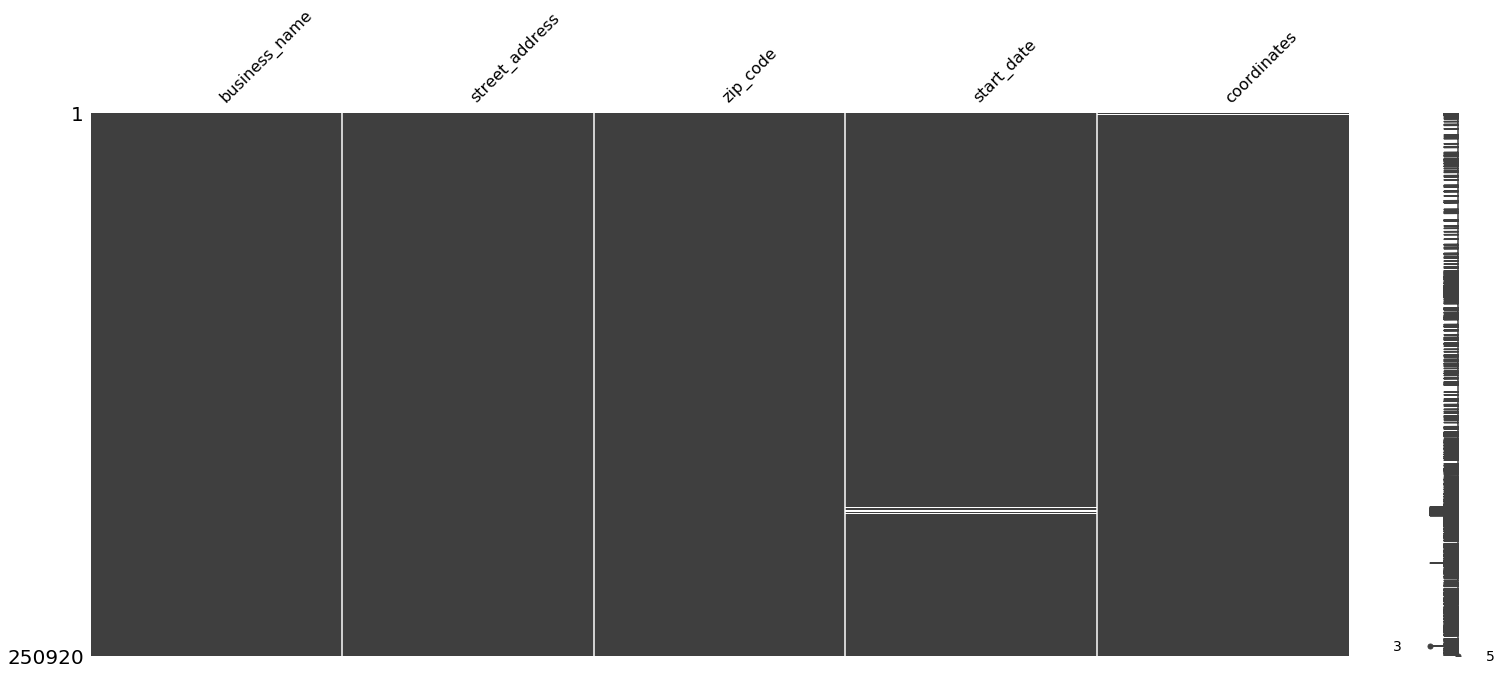

In [81]:
msno.matrix(business_df)

In [82]:
# dropping na coordinate values
business_df = business_df.dropna()

In [83]:
# dropping coordinates of (0,0) and resetting the index to start from 0
business_df = business_df[business_df['coordinates'] != '(0, 0)'].reset_index()
business_df.shape

(245437, 6)

In [84]:
business_df.loc[1]['coordinates']

'(34.044, -118.292)'

As the coordinate variable is a string with the latitude and longitude values, we shall use regex functions to pull the latitude and longtitude variables out and convert them to a float type. 

Here we use positive lookbehind and positive lookahead to target the exact part of the string that we need because each latitude and longitude pair has the same structure.

In [85]:
# regex to extract latitude
def get_lat(coords):
    lat = re.compile('(?<=\().+(?=\,)')
    return float(lat.search(coords).group())

# regex to extract longitude
def get_long(coords):
    long = re.compile('(?<=\, ).+(?=\))')
    return float(long.search(coords).group())

print("latitude: " + str(get_lat(business_df.loc[1]['coordinates'])) + " longitude: " + str(get_long(business_df.loc[1]['coordinates'])))

latitude: 34.044 longitude: -118.292


In [86]:
# apply get_lat and get_long functions to create new columns representing latitude and longitude for each business
business_df['latitude'] = business_df['coordinates'].apply(get_lat)
business_df['longitude'] = business_df['coordinates'].apply(get_long)
business_df = business_df.drop(['coordinates'],axis=1)
business_df.head()

,index,business_name,street_address,zip_code,start_date,latitude,longitude
0,10,CORALIE WHITCOMB,2669 MEDLOW AVENUE,90065-4616,06/10/2017,34.1269,-118.2247
1,56,RMJC INSURANCE SERVICES INC,1601 S VERMONT AVENUE SUITE #103,90006-4541,03/07/2017,34.0440,-118.2920
2,59,DANIELLE HALFERTY,2527 CANYON DRIVE,90068-2415,09/18/2017,34.1164,-118.3165
3,61,PETER J HARRIS,4153 MARLTON AVENUE #3,90008-3525,01/01/1998,34.0101,-118.3416
4,62,CARNIVAL LUXE LLC,234 S FIGUEROA STREET APARTMENT #1235,90012-2525,12/06/2016,34.0559,-118.2536


### Traffic collisions 2010-2018

https://www.kaggle.com/cityofLA/los-angeles-traffic-collision-data/version/7#traffic-collision-data-from-2010-to-present.csv

In [87]:
traffic_df = pd.read_csv('../data/external/traffic_collisions_2010_2018.csv')

In [88]:
traffic_df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,100119684,11042010-01-01T00:00:00,2010-11-04T00:00:00,1345,1,Central,159,997,TRAFFIC COLLISION,NaN,20.0,F,H,101.0,STREET,7TH ST,LAWRENCE ST,"{'needs_recoding': False, 'longitude': '-118.2..."
1,101221255,8102010-01-01T00:00:00,2010-08-10T00:00:00,1900,12,77th Street,1211,997,TRAFFIC COLLISION,NaN,31.0,F,B,101.0,STREET,54TH ST,3RD AV,"{'needs_recoding': False, 'longitude': '-118.3..."
2,101414426,6112010-01-01T00:00:00,2010-06-09T00:00:00,1925,14,Pacific,1488,997,TRAFFIC COLLISION,NaN,40.0,F,B,101.0,STREET,MANCHESTER BL,BELLANCA AV,"{'needs_recoding': False, 'longitude': '-118.3..."
3,102109168,4062010-01-01T00:00:00,2010-04-06T00:00:00,1445,21,Topanga,2197,997,TRAFFIC COLLISION,1501,51.0,M,O,101.0,STREET,ROSITA AV,CORBIN AV,"{'needs_recoding': False, 'longitude': '-118.5..."
4,100322445,9222010-01-01T00:00:00,2010-05-23T00:00:00,1805,3,Southwest,397,997,TRAFFIC COLLISION,NaN,32.0,F,H,101.0,STREET,43RD PL,WALTON AV,"{'needs_recoding': False, 'longitude': '-118.2..."


In [89]:
traffic_df['Victim Descent'].unique()

array(['H', 'B', 'O', 'W', 'X', 'A', nan, 'K', 'C', 'F', 'U', 'J', 'P',
       'V', 'Z', 'I', 'G', 'S', 'D', 'L', '-'], dtype=object)

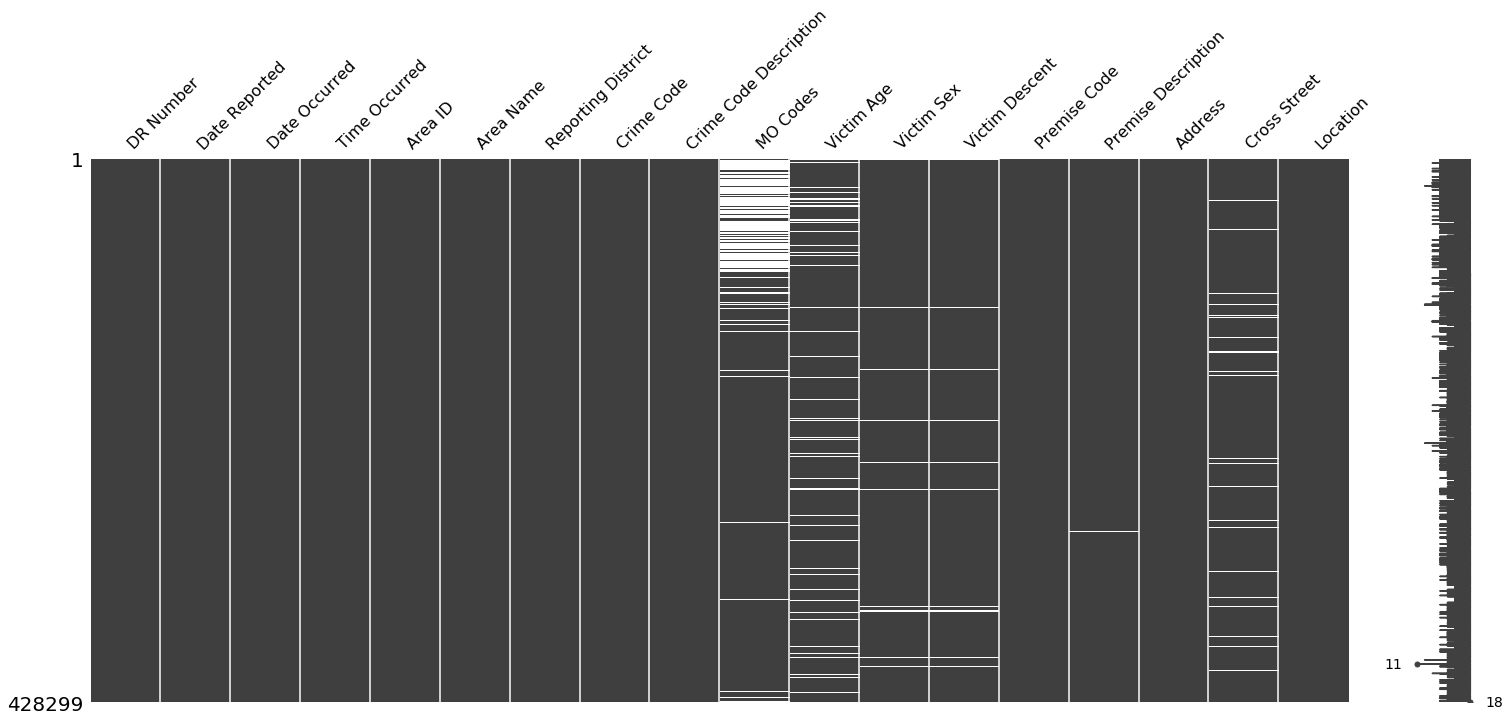

In [90]:
msno.matrix(traffic_df)

In [91]:
traffic_df = traffic_df[['Date Occurred', 'Time Occurred', 'Area Name', 'Victim Age', 
                         'Victim Sex', 'Victim Descent', 'Address', 'Cross Street', 'Location']]
traffic_df = traffic_df.rename(columns = {'Date Occurred':'date_occured', 
                             'Time Occurred':'time_occured', 'Area Name':'area_name', 'Victim Age':'victim_age', 
                             'Victim Sex':'victim_sex', 'Victim Descent':'victim_descent', 'Address':'address', 
                             'Cross Street':'cross_street', 'Location':'location'})
traffic_df.head()

,date_occured,time_occured,area_name,victim_age,victim_sex,victim_descent,address,cross_street,location
0,2010-11-04T00:00:00,1345,Central,20.0,F,H,7TH ST,LAWRENCE ST,"{'needs_recoding': False, 'longitude': '-118.2..."
1,2010-08-10T00:00:00,1900,77th Street,31.0,F,B,54TH ST,3RD AV,"{'needs_recoding': False, 'longitude': '-118.3..."
2,2010-06-09T00:00:00,1925,Pacific,40.0,F,B,MANCHESTER BL,BELLANCA AV,"{'needs_recoding': False, 'longitude': '-118.3..."
3,2010-04-06T00:00:00,1445,Topanga,51.0,M,O,ROSITA AV,CORBIN AV,"{'needs_recoding': False, 'longitude': '-118.5..."
4,2010-05-23T00:00:00,1805,Southwest,32.0,F,H,43RD PL,WALTON AV,"{'needs_recoding': False, 'longitude': '-118.2..."


In [92]:
traffic_df.dtypes

date_occured       object
time_occured        int64
area_name          object
victim_age        float64
victim_sex         object
victim_descent     object
address            object
cross_street       object
location           object
dtype: object

In [93]:
traffic_df['date_occured'] = pd.to_datetime(traffic_df['date_occured'])

In [94]:
traffic_df.loc[1]['location']

'{\'needs_recoding\': False, \'longitude\': \'-118.3203\', \'human_address\': \'{"address":"","city":"","state":"","zip":""}\', \'latitude\': \'33.9932\'}'

In [95]:
def get_lat(coords):
    lat = re.compile('(?<=latitude\': \').+(?=\'})')
    return(float(lat.search(coords).group()))

def get_long(coords):
    long = re.compile('(?<=longitude\': \').+(?=\', \'h)')
    return float(long.search(coords).group())

traffic_df['latitude'] = traffic_df['location'].apply(get_lat)
traffic_df['longitude'] = traffic_df['location'].apply(get_long)
traffic_df = traffic_df.drop('location',1)
traffic_df.head()

,date_occured,time_occured,area_name,victim_age,victim_sex,victim_descent,address,cross_street,latitude,longitude
0,2010-11-04,1345,Central,20.0,F,H,7TH ST,LAWRENCE ST,34.0348,-118.2362
1,2010-08-10,1900,77th Street,31.0,F,B,54TH ST,3RD AV,33.9932,-118.3203
2,2010-06-09,1925,Pacific,40.0,F,B,MANCHESTER BL,BELLANCA AV,33.9599,-118.3805
3,2010-04-06,1445,Topanga,51.0,M,O,ROSITA AV,CORBIN AV,34.1585,-118.5633
4,2010-05-23,1805,Southwest,32.0,F,H,43RD PL,WALTON AV,34.0055,-118.2948


In [96]:
traffic_df.dtypes

date_occured      datetime64[ns]
time_occured               int64
area_name                 object
victim_age               float64
victim_sex                object
victim_descent            object
address                   object
cross_street              object
latitude                 float64
longitude                float64
dtype: object

In [97]:
rides_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_address,start_zip,start_name,start_docks,end_address,end_zip,end_name,end_docks,charged_ride,start_hour,active_6m,annual,monthly,one_day,walk_up,one_way,round_trip,time_block_count,time_block_count_post_free
0,33404951,36,2017-07-01 00:09:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,5996,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
1,33404950,13,2017-07-01 00:10:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,5777,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0
2,33404947,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6342,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
3,33404948,34,2017-07-01 00:11:00,2017-07-01 00:45:00,3018,34.043732,-118.260139,3018,34.043732,-118.260139,6478,0,Round Trip,Walk-up,919 S Grand Ave,90015,Grand & Olympic,22.0,919 S Grand Ave,90015,Grand & Olympic,22.0,1,0,1,0,0,0,1,0,1,2,1
4,33404949,12,2017-07-01 00:11:00,2017-07-01 00:23:00,3055,34.044159,-118.251579,3082,34.046520,-118.237411,6411,0,One Way,Walk-up,111 W 7th Street,90014,7th & Main,23.0,599 Traction Ave,90013,Traction & Rose,27.0,0,0,1,0,0,0,1,1,0,1,0


In [98]:
# len(rides_df[(rides_df['start_time'] > datetime.date(2018,6,1)) & (rides_df['start_time'] < datetime.date(2018,7,1))])

In [99]:
# len(rides_df[(rides_df['start_time'] > datetime.date(2018,5,1)) & (rides_df['start_time'] < datetime.date(2018,6,1))])

In [100]:
# # Import the necessary packages
# import numpy
# from cvxopt import matrix
# from cvxopt import solvers
# # Define QP parameters (directly)
# P = matrix([[-1.0,0.0],[0.0,0.0]])
# q = matrix([-3.0,-4.0])
# G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
# h = matrix([0.0,0.0,-15.0,100.0,80.0])
# # Define QP parameters (with NumPy)
# # P = matrix(numpy.diag([1,0]), tc=’d’)
# # q = matrix(numpy.array([3,4]), tc=’d’)
# # G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc=’d’)
# # h = matrix(numpy.array([0,0,-15,100,80]), tc=’d’)
# # Construct the QP, invoke solver
# sol = solvers.qp(P,q,G,h)
# # Extract optimal value and solution
# sol['x'] # [7.13e-07, 5.00e+00]
# sol['primal objective'] # 20.0000061731

### Potential EDA:
1. Planning inventory around locations and time
    1. Most common start, end station pairings
    2. Most common time periods
    3. Different heatmaps for different time periods
    4. Start/end station correlation with available docks at location
2. Pricing strategies for different passes
    1. Usage rates across different passes
        1. By duration
        2. By number of trips
        3. Total duration X trips
    2. Geographical gropuing of where most passes originate/end from
    3. Cohort analysis of different groups
    4. How many rides were past the free 30 minute mark?
3. Unit pricing strategies, what if we brought it back? Charging all > 
    1. Based on current pricing strategy, what would total revenue be on a per mile basis
    2. Comparison with Bird/Jump bike pricing
    3. Cohort analysis of different groups
    4. Optimization function for 2 and 3

Pricing strategies can be used to build predictor model for rides, duration, and total revenue

### Feature engineering
1. Hours
2. Free ride with pass? (>30 in time or not)
3. Active or none active bikes (whether they've been used in the past month)
4. Number of 30 minute blocks
5. One hot encoding pass type
6. One hot encoding route type (one way, round trip)

In [101]:
# Constants

daily_pass = agg_pass_groups['new_pass_prices']['daily']
monthly_pass = agg_pass_groups['new_pass_prices']['monthly']
annual_pass = 150

walk_up_share = agg_pass_groups['percent_total_trips']['walk_up']
daily_share = agg_pass_groups['percent_total_trips']['daily']
monthly_share = agg_pass_groups['percent_total_trips']['monthly']
annual_share = agg_pass_groups['percent_total_trips']['annual']

walk_up_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['walk_up']
daily_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['daily']
monthly_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['monthly']
annual_charged_blocks = agg_pass_groups['average_charged_blocks_per_ride']['annual']

0.017066066148465685 -734.3868612370609


(0, 5)

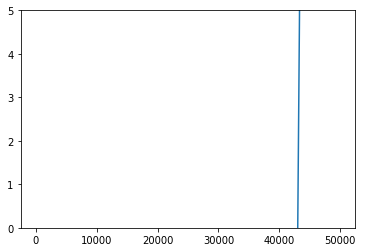

In [102]:
weighted_slope = walk_up_share * slope_walk_up + daily_share * slope_daily + monthly_share * slope_monthly + annual_share * slope_monthly
weighted_intercept = walk_up_share * intercept_walk_up + daily_share * intercept_daily + monthly_share * intercept_monthly + annual_share * intercept_monthly
print(weighted_slope, weighted_intercept)
def weighted_demand(x):
    return weighted_slope * x + weighted_intercept
plt.plot(q, weighted_demand(q))
plt.ylim((0,5))

0.013133045523328685 -563.5662939315079


(0, 5)

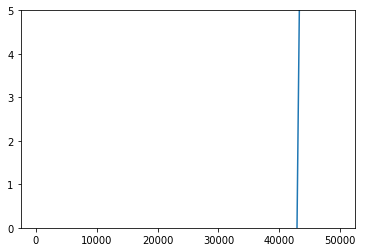

In [103]:
walk_up_share_new = new_riders['percent_total_trips']['Walk-up']
daily_share_new = new_riders['percent_total_trips']['One Day Pass']
monthly_share_new = new_riders['percent_total_trips']['Monthly Pass']
annual_share_new = new_riders['percent_total_trips']['Flex Pass']

weighted_slope_new = walk_up_share_new * slope_walk_up + daily_share_new * slope_daily + monthly_share_new * slope_monthly + annual_share_new * slope_monthly
weighted_intercept_new = walk_up_share_new * intercept_walk_up + daily_share_new * intercept_daily + monthly_share_new * intercept_monthly + annual_share_new * intercept_monthly
print(weighted_slope_new, weighted_intercept_new)
def weighted_demand_new(x):
    return weighted_slope_new * x + weighted_intercept_new
plt.plot(q, weighted_demand_new(q))
plt.ylim((0,5))

In [104]:
from scipy.optimize import minimize

# Base quadratic with demand curve.

def objective(x):
    rate = x[0]
    riders = x[1]
    
    walk_up_rev = riders * walk_up_share * walk_up_charged_blocks * rate
    day_rev = riders * daily_share * daily_charged_blocks * rate
    month_rev = riders * monthly_share * monthly_charged_blocks * rate
    annual_rev = riders * annual_share * annual_charged_blocks * rate
    
    day_pass_rev = riders * daily_share * daily_pass
    month_pass_rev = riders * monthly_share * monthly_pass
    annual_pass_rev = riders * annual_share * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + annual_rev + day_pass_rev + month_pass_rev + annual_pass_rev
    return -total_revenue

def demand_constraint(x):
    rate = x[0]
    riders = x[1]
    return rate - slope * riders - intercept

cons = {'type':'eq', 'fun':demand_constraint}
    
b1 = (1.5, 2.5)
b2 = (50000, 140000)

bnds = (b1,b2)

x0 = np.array([1.75, 77357])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

print(sol)
print(-round(sol['fun']))

     fun: -1623030.3308773183
     jac: array([-5.59883906e+04, -1.65781250e+01])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([1.50000000e+00, 9.78438571e+04])
1623030


In [105]:
price_range_1 = (1, 2.5)
price_range_2 = (1.25, 2.5)
price_range_3 = (1.5, 2.5)
price_range_4 = (1.75, 2.5)

rider_range_1 = (50000, 80000)
rider_range_2 = (50000, 100000)
rider_range_3 = (50000, 120000)
rider_range_4 = (50000, 140000)

bounds = [((price_range_1, rider_range_1)) , ((price_range_1, rider_range_2)) , ((price_range_1, rider_range_3))
          , ((price_range_1, rider_range_4)) , ((price_range_2, rider_range_1)) , ((price_range_2, rider_range_2))
          , ((price_range_2, rider_range_3)) , ((price_range_2, rider_range_4)) , ((price_range_3, rider_range_1))
          , ((price_range_3, rider_range_2)) , ((price_range_3, rider_range_3)) , ((price_range_3, rider_range_4))
          , ((price_range_4, rider_range_1)) , ((price_range_4, rider_range_2)) , ((price_range_4, rider_range_3))
          , ((price_range_4, rider_range_4))
          ]

sensitivity_results = [minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds) for bnds in bounds]
sensitivity_total_rev = [-round(sol['fun']) for sol in sensitivity_results]
sensitivity_rate = [round(sol['x'][0]) for sol in sensitivity_results]
sensitivity_riders = [round(sol['x'][1]) for sol in sensitivity_results]
price_ranges = [pair[0] for pair in bounds]
rider_ranges = [pair[1] for pair in bounds]

sensitivity_sorted = sorted(list(zip(sensitivity_total_rev, sensitivity_rate, sensitivity_riders, price_ranges, 
                                     rider_ranges)), reverse = True)

print('Total rev | Rate charged | Total riders | Rate range | Rider range')
for test_i in range(len(sensitivity_sorted)):
    print(sensitivity_sorted[test_i][0], '   ',sensitivity_sorted[test_i][1], '          ',
          sensitivity_sorted[test_i][2], 
          '     ',sensitivity_sorted[test_i][3], '   ', sensitivity_sorted[test_i][4])

Total rev | Rate charged | Total riders | Rate range | Rider range
1678530     1.0            102966.0       (1, 2.5)     (50000, 140000)
1678530     1.0            102966.0       (1, 2.5)     (50000, 120000)
1651146     1.0            100405.0       (1.25, 2.5)     (50000, 140000)
1651146     1.0            100405.0       (1.25, 2.5)     (50000, 120000)
1646752     1.0            100000.0       (1.25, 2.5)     (50000, 100000)
1646752     1.0            100000.0       (1, 2.5)     (50000, 100000)
1623030     2.0            97844.0       (1.5, 2.5)     (50000, 140000)
1623030     2.0            97844.0       (1.5, 2.5)     (50000, 120000)
1623030     2.0            97844.0       (1.5, 2.5)     (50000, 100000)
1594182     2.0            95283.0       (1.75, 2.5)     (50000, 140000)
1594182     2.0            95283.0       (1.75, 2.5)     (50000, 120000)
1594182     2.0            95283.0       (1.75, 2.5)     (50000, 100000)
1372815     2.0            80000.0       (1.75, 2.5)     (50000

In [106]:
# Using weighted demand curve.

def objective(x):
    rate = x[0]
    riders = x[1]
    
    walk_up_rev = riders * walk_up_share * walk_up_charged_blocks * rate
    day_rev = riders * daily_share * daily_charged_blocks * rate
    month_rev = riders * monthly_share * monthly_charged_blocks * rate
    annual_rev = riders * annual_share * annual_charged_blocks * rate
    
    day_pass_rev = riders * daily_share * daily_pass
    month_pass_rev = riders * monthly_share * monthly_pass
    annual_pass_rev = riders * annual_share * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + annual_rev + day_pass_rev + month_pass_rev + annual_pass_rev
    return -total_revenue

def demand_constraint(x):
    rate = x[0]
    riders = x[1]
    return rate - weighted_slope_new * riders - weighted_intercept_new

cons = {'type':'eq', 'fun':demand_constraint}
    
b1 = (1, 2.5)
b2 = (50000, 140000)

bnds = (b1,b2)

x0 = np.array([1.75, 77357])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

print(sol)
print(-round(sol['fun']))

     fun: -1327742.6233361303
     jac: array([-4.42747656e+04, -1.71562500e+01])
 message: 'Positive directional derivative for linesearch'
    nfev: 50
     nit: 9
    njev: 5
  status: 8
 success: False
       x: array([2.50000000e+00, 7.73734432e+04])
1327743


In [112]:
new_riders['total_trips']

passholder_type
Annual Pass        12
Flex Pass        1577
Monthly Pass    43967
One Day Pass     4737
Walk-up         44990
Name: total_trips, dtype: int64

In [109]:
# Incorporating segmented demand curves

def objective(x):
    walk_rate = x[0]
    walk_riders = x[1]
    day_rate = x[2]
    day_riders = x[3]
    month_rate = x[4]
    month_riders = x[5]
    annual_rate = x[6]
    
    walk_up_rev = walk_riders * walk_up_charged_blocks * walk_rate
    day_rev = day_riders * daily_charged_blocks * day_rate
    month_rev = month_riders * monthly_charged_blocks * month_rate
    
    annual_riders = (walk_riders + day_riders + month_riders)*(annual_share_new/(walk_up_share_new + daily_share_new
                                                                                 + monthly_share_new))
    annual_rev = annual_riders * annual_charged_blocks * annual_rate
    
    day_pass_rev = day_riders * daily_pass
    month_pass_rev = month_riders * monthly_pass
    annual_pass_rev = annual_riders * annual_pass
    
    total_revenue = walk_up_rev + day_rev + month_rev + annual_rev + day_pass_rev + month_pass_rev + annual_pass_rev
    return -total_revenue

def demand_constraint(x):
    rate = x[0]
    riders = x[1]
    return rate - slope * riders - intercept

cons = {'type':'eq', 'fun':demand_constraint}
    
b1 = (1.5, 2.5)
b2 = (50000, 150000)

bnds = (b1,b2)

x0 = np.array([1.75, 77357])

sol = minimize(objective, x0, method='SLSQP', constraints=cons, bounds=bnds)

IndexError: index 2 is out of bounds for axis 0 with size 2